In [1]:
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings('ignore')

df = pd.read_csv('no_summaries_cleaned_modeling_features.csv')

print("=" * 80)
print("5.1 EXPLORATORY DATA ANALYSIS")
print("=" * 80)

# ============================================================================
# 5.1 Dataset Size and Demographics
# ============================================================================
print("\n### 5.1.1 Dataset Size and Demographics\n")

print(f"Total number of records: {len(df):,}")
print(f"Total number of unique cases: {df['citationcomplaintnumber'].nunique():,}")
print(f"Date range: {df['offense_year'].min():.0f} - {df['offense_year'].max():.0f}")

print("\n--- Demographics Distribution ---")
print(f"\nAge at Offense Statistics:")
print(f"  Mean: {df['age_at_offense'].mean():.2f} years")
print(f"  Median: {df['age_at_offense'].median():.2f} years")
print(f"  Std Dev: {df['age_at_offense'].std():.2f} years")
print(f"  Range: {df['age_at_offense'].min():.0f} - {df['age_at_offense'].max():.0f} years")

print("\n--- Age Group Distribution ---")
age_group_counts = df['age_group'].value_counts().sort_index()
age_group_pct = (age_group_counts / len(df) * 100).round(2)
for group in age_group_counts.index:
    print(f"  {group}: {age_group_counts[group]:,} ({age_group_pct[group]:.2f}%)")

print("\n--- Sex Distribution (dv_flag as proxy) ---")
sex_counts = df['dv_flag'].value_counts()
sex_pct = (sex_counts / len(df) * 100).round(2)
print(f"  dv_flag=0: {sex_counts.get(0, 0):,} ({sex_pct.get(0, 0):.2f}%)")
print(f"  dv_flag=1: {sex_counts.get(1, 0):,} ({sex_pct.get(1, 0):.2f}%)")

print("\n--- Jurisdiction Distribution ---")
county_dist = df['county'].value_counts().head(10)
print("Top 10 counties by case volume:")
for county, count in county_dist.items():
    print(f"  {county}: {count:,} ({count/len(df)*100:.2f}%)")

# ============================================================================
# 5.1.2 Data Quality Insights
# ============================================================================
print("\n\n### 5.1.2 Data Quality Insights\n")

print("--- Missing Values ---")
missing_counts = df.isnull().sum()
missing_cols = missing_counts[missing_counts > 0].sort_values(ascending=False)
if len(missing_cols) > 0:
    print("Columns with missing data:")
    for col, count in missing_cols.items():
        pct = count / len(df) * 100
        print(f"  {col}: {count:,} ({pct:.2f}%)")
else:
    print("  No missing values detected")

print("\n--- Offense Characteristics Distribution ---")
print(f"\nDrug-related offenses: {df['drug_flag'].sum():,} ({df['drug_flag'].sum()/len(df)*100:.2f}%)")
print(f"Violent offenses: {df['violent_flag'].sum():,} ({df['violent_flag'].sum()/len(df)*100:.2f}%)")
print(f"Property offenses: {df['property_flag'].sum():,} ({df['property_flag'].sum()/len(df)*100:.2f}%)")

print("\n--- Charge Severity Statistics ---")
print(f"Max charge severity - Mean: {df['max_charge_severity'].mean():.2f}, Median: {df['max_charge_severity'].median():.0f}")
print(f"Avg charge severity - Mean: {df['avg_charge_severity'].mean():.2f}, Median: {df['avg_charge_severity'].median():.2f}")

print("\n--- Prior Criminal History ---")
print(f"Defendants with prior offenses: {df['has_prior_offense'].sum():,} ({df['has_prior_offense'].sum()/len(df)*100:.2f}%)")
print(f"Defendants with prior recidivism: {df['prev_recid_flag'].sum():,} ({df['prev_recid_flag'].sum()/len(df)*100:.2f}%)")

print("\n--- Conviction and Case Status ---")
print(f"Convicted: {df['conv_flag'].sum():,} ({df['conv_flag'].sum()/len(df)*100:.2f}%)")
print(f"Juvenile cases: {df['juvflag'].sum():,} ({df['juvflag'].sum()/len(df)*100:.2f}%)")

print("\n" + "=" * 80)
print("5.2 RECIDIVISM PATTERNS")
print("=" * 80)

# ============================================================================
# 5.2.1 Overall Recidivism Rates
# ============================================================================
print("\n### 5.2.1 Overall Recidivism Rates\n")

total_defendants = df['citationcomplaintnumber'].nunique()
recid_count = df[df['pretrial_recidivism'] == 1]['citationcomplaintnumber'].nunique()
statewide_recid_rate = (recid_count / total_defendants) * 100

print(f"Statewide Pretrial Recidivism Rate: {statewide_recid_rate:.2f}%")
print(f"  Total defendants: {total_defendants:,}")
print(f"  Defendants who reoffended: {recid_count:,}")
print(f"  Defendants who did not reoffend: {total_defendants - recid_count:,}")

# ============================================================================
# 5.2.2 Recidivism by Demographics
# ============================================================================
print("\n### 5.2.2 Recidivism by Demographics\n")

# By Sex (using dv_flag as proxy)
print("--- Recidivism by Sex (dv_flag) ---")
for sex_val in sorted(df['dv_flag'].dropna().unique()):
    sex_data = df[df['dv_flag'] == sex_val]
    unique_defs = sex_data['citationcomplaintnumber'].nunique()
    recid_defs = sex_data[sex_data['pretrial_recidivism'] == 1]['citationcomplaintnumber'].nunique()
    rate = (recid_defs / unique_defs * 100) if unique_defs > 0 else 0
    sex_label = "Female" if sex_val == 1 else "Male"
    print(f"  {sex_label}: {rate:.2f}% ({recid_defs}/{unique_defs})")

# By Age Group
print("\n--- Recidivism by Age Group ---")
age_groups_order = ['Under 25', '25-34', '35-44', '45+']
for age_grp in age_groups_order:
    if age_grp in df['age_group'].values:
        age_data = df[df['age_group'] == age_grp]
        unique_defs = age_data['citationcomplaintnumber'].nunique()
        recid_defs = age_data[age_data['pretrial_recidivism'] == 1]['citationcomplaintnumber'].nunique()
        rate = (recid_defs / unique_defs * 100) if unique_defs > 0 else 0
        print(f"  {age_grp}: {rate:.2f}% ({recid_defs}/{unique_defs})")

# Continuous age analysis
print("\n--- Age as Continuous Predictor ---")
age_corr = df['age_at_offense'].corr(df['pretrial_recidivism'])
print(f"  Correlation with recidivism: {age_corr:.4f}")
print(f"  Mean age - Reoffenders: {df[df['pretrial_recidivism']==1]['age_at_offense'].mean():.2f} years")
print(f"  Mean age - Non-reoffenders: {df[df['pretrial_recidivism']==0]['age_at_offense'].mean():.2f} years")

# ============================================================================
# 5.2.3 Recidivism by Offense Characteristics
# ============================================================================
print("\n### 5.2.3 Recidivism by Offense Characteristics\n")

# By Charge Severity
print("--- Recidivism by Max Charge Severity ---")
severity_bins = sorted(df['max_charge_severity'].dropna().unique())
for sev in severity_bins:
    sev_data = df[df['max_charge_severity'] == sev]
    unique_defs = sev_data['citationcomplaintnumber'].nunique()
    recid_defs = sev_data[sev_data['pretrial_recidivism'] == 1]['citationcomplaintnumber'].nunique()
    rate = (recid_defs / unique_defs * 100) if unique_defs > 0 else 0
    print(f"  Severity {int(sev)}: {rate:.2f}% ({recid_defs}/{unique_defs})")

# By Crime Categories
print("\n--- Recidivism by Crime Category ---")
drug_data = df[df['drug_flag'] == 1]
violent_data = df[df['violent_flag'] == 1]
property_data = df[df['property_flag'] == 1]
other_data = df[(df['drug_flag'] == 0) & (df['violent_flag'] == 0) & (df['property_flag'] == 0)]

for label, data in [('Drug-related', drug_data), ('Violent', violent_data), 
                     ('Property', property_data), ('Other/Mixed', other_data)]:
    if len(data) > 0:
        unique_defs = data['citationcomplaintnumber'].nunique()
        recid_defs = data[data['pretrial_recidivism'] == 1]['citationcomplaintnumber'].nunique()
        rate = (recid_defs / unique_defs * 100) if unique_defs > 0 else 0
        print(f"  {label}: {rate:.2f}% ({recid_defs}/{unique_defs})")

# By Number of Charges
print("\n--- Recidivism by Number of Charges in Case ---")
for num_ch in sorted(df['num_charges_case'].dropna().unique())[:5]:
    charge_data = df[df['num_charges_case'] == num_ch]
    unique_defs = charge_data['citationcomplaintnumber'].nunique()
    recid_defs = charge_data[charge_data['pretrial_recidivism'] == 1]['citationcomplaintnumber'].nunique()
    rate = (recid_defs / unique_defs * 100) if unique_defs > 0 else 0
    print(f"  {int(num_ch)} charge(s): {rate:.2f}% ({recid_defs}/{unique_defs})")

# By Prior Criminal History
print("\n--- Recidivism by Prior Criminal History ---")
prior_data = df[df['has_prior_offense'] == 1]
no_prior_data = df[df['has_prior_offense'] == 0]

for label, data in [('With prior offenses', prior_data), ('Without prior offenses', no_prior_data)]:
    unique_defs = data['citationcomplaintnumber'].nunique()
    recid_defs = data[data['pretrial_recidivism'] == 1]['citationcomplaintnumber'].nunique()
    rate = (recid_defs / unique_defs * 100) if unique_defs > 0 else 0
    print(f"  {label}: {rate:.2f}% ({recid_defs}/{unique_defs})")

# By Prior Recidivism Flag
print("\n--- Recidivism by Prior Recidivism History ---")
prev_recid_data = df[df['prev_recid_flag'] == 1]
no_prev_recid_data = df[df['prev_recid_flag'] == 0]

for label, data in [('Prior recidivism history', prev_recid_data), ('No prior recidivism', no_prev_recid_data)]:
    unique_defs = data['citationcomplaintnumber'].nunique()
    recid_defs = data[data['pretrial_recidivism'] == 1]['citationcomplaintnumber'].nunique()
    rate = (recid_defs / unique_defs * 100) if unique_defs > 0 else 0
    print(f"  {label}: {rate:.2f}% ({recid_defs}/{unique_defs})")

print("\n" + "=" * 80)

5.1 EXPLORATORY DATA ANALYSIS

### 5.1.1 Dataset Size and Demographics

Total number of records: 431,920
Total number of unique cases: 381,376
Date range: 1915 - 2018

--- Demographics Distribution ---

Age at Offense Statistics:
  Mean: 33.23 years
  Median: 30.89 years
  Std Dev: 10.95 years
  Range: -79 - 175 years

--- Age Group Distribution ---
  25-34: 159,320 (36.89%)
  35-44: 89,438 (20.71%)
  45_Plus: 69,318 (16.05%)
  Under_25: 113,817 (26.35%)
  Unknown: 27 (0.01%)

--- Sex Distribution (dv_flag as proxy) ---
  dv_flag=0: 431,920 (100.00%)
  dv_flag=1: 0 (0.00%)

--- Jurisdiction Distribution ---
Top 10 counties by case volume:
  Allegheny: 82,188 (19.03%)
  Montgomery: 22,156 (5.13%)
  York: 21,091 (4.88%)
  Delaware: 20,268 (4.69%)
  Dauphin: 20,194 (4.68%)
  Bucks: 16,271 (3.77%)
  Lancaster: 16,050 (3.72%)
  Lehigh: 15,696 (3.63%)
  Chester: 14,335 (3.32%)
  Unknown: 14,277 (3.31%)


### 5.1.2 Data Quality Insights

--- Missing Values ---
  No missing values detected

--

Creating visualization for 5.2.1 Overall Recidivism Rates...



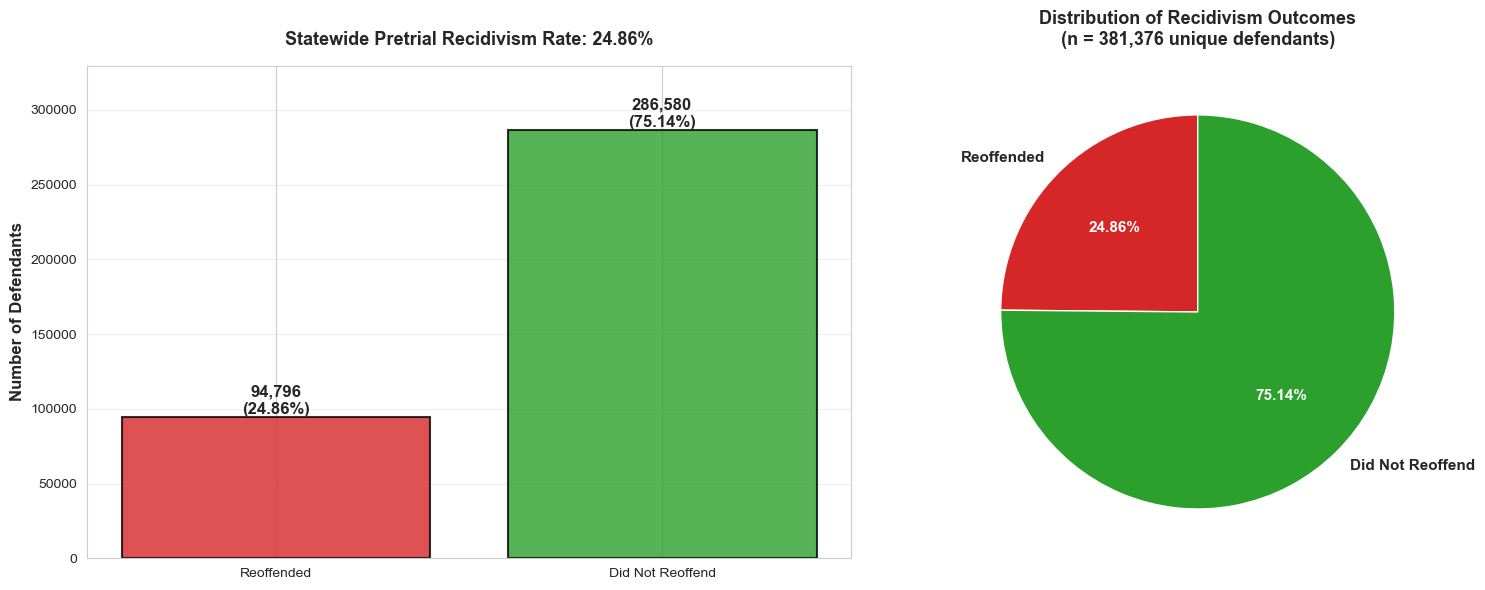

✓ Visualization saved as '5_2_1_overall_recidivism_rate.png'

Creating visualization for 5.2.2 Recidivism by Demographics...



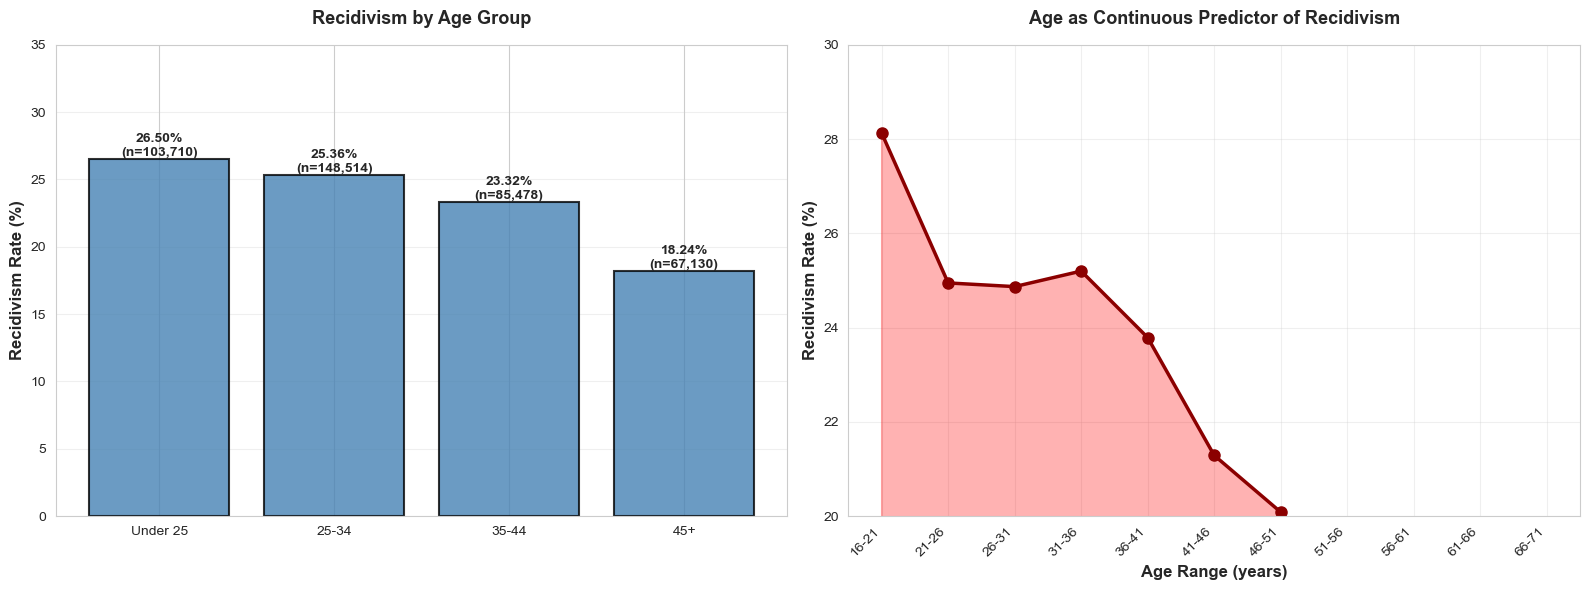

✓ Visualization saved as '5_2_2_recidivism_by_demographics.png'

Creating visualization for 5.2.3 Recidivism by Offense Characteristics...



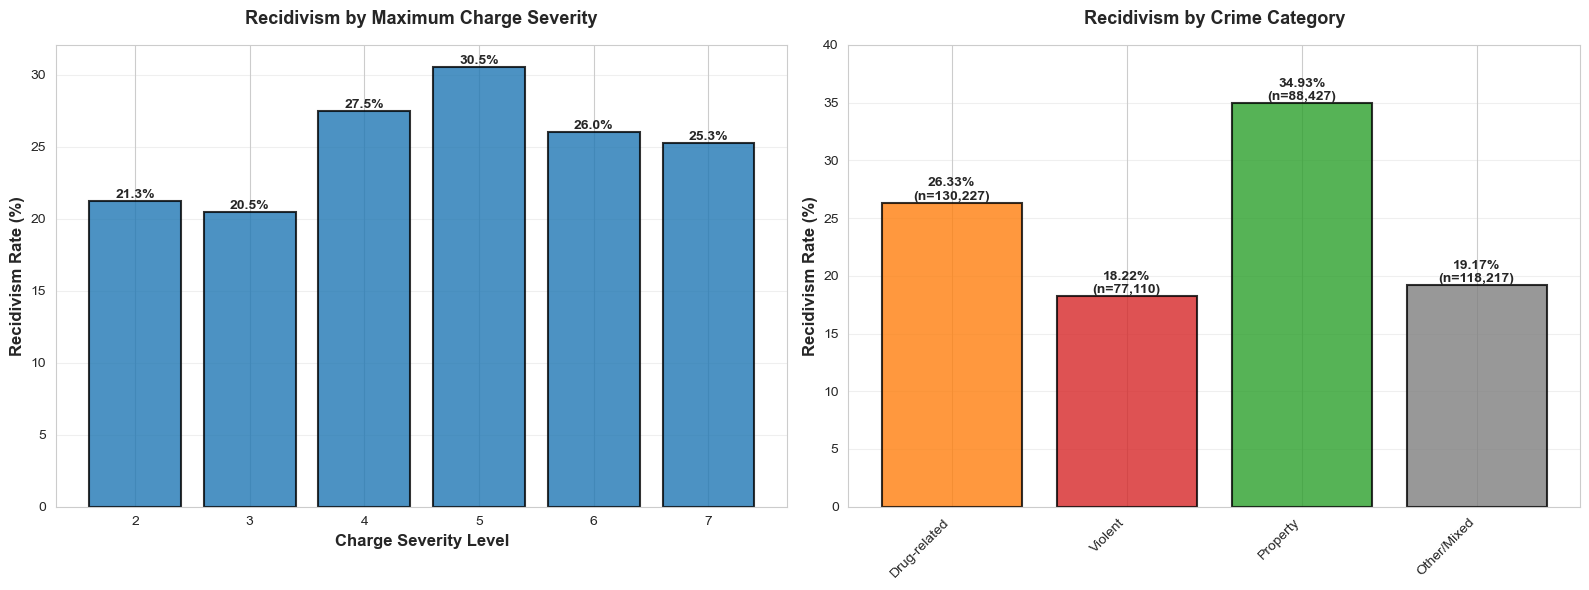

✓ Visualization saved as '5_2_3a_recidivism_severity_and_category.png'



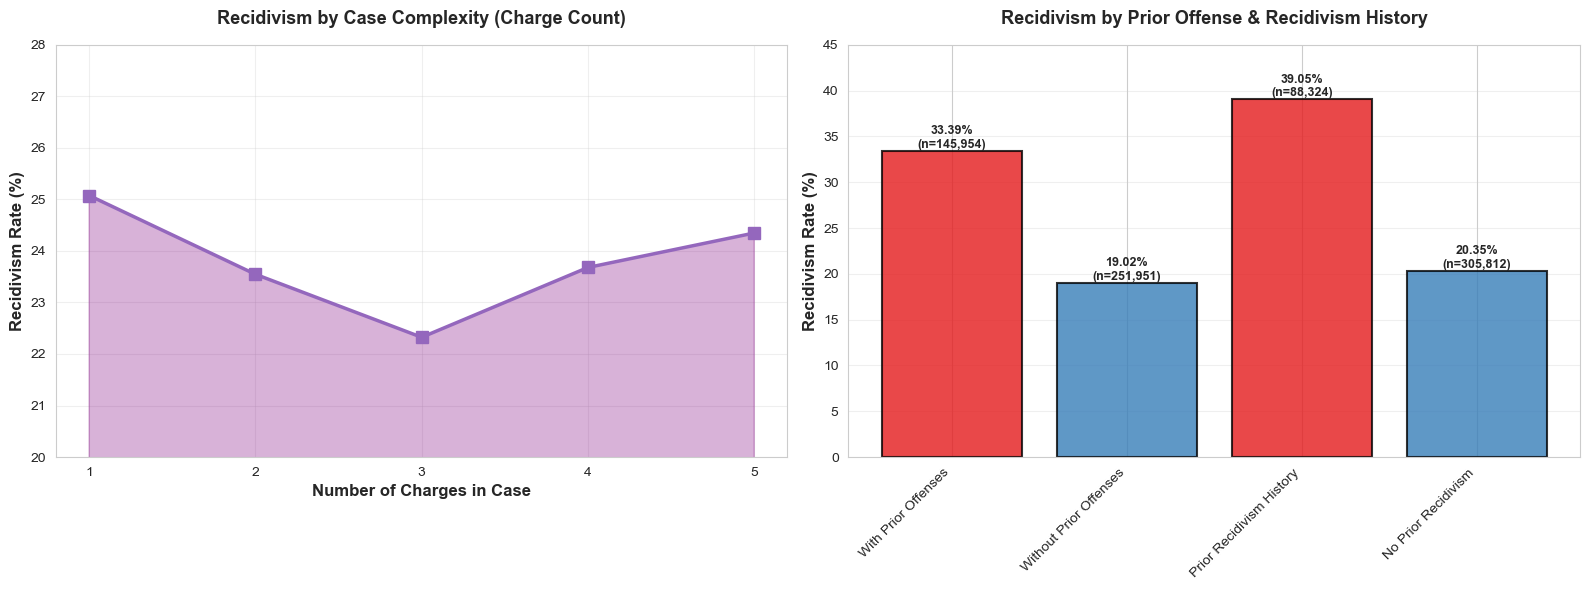

✓ Visualization saved as '5_2_3b_recidivism_charge_count_and_history.png'



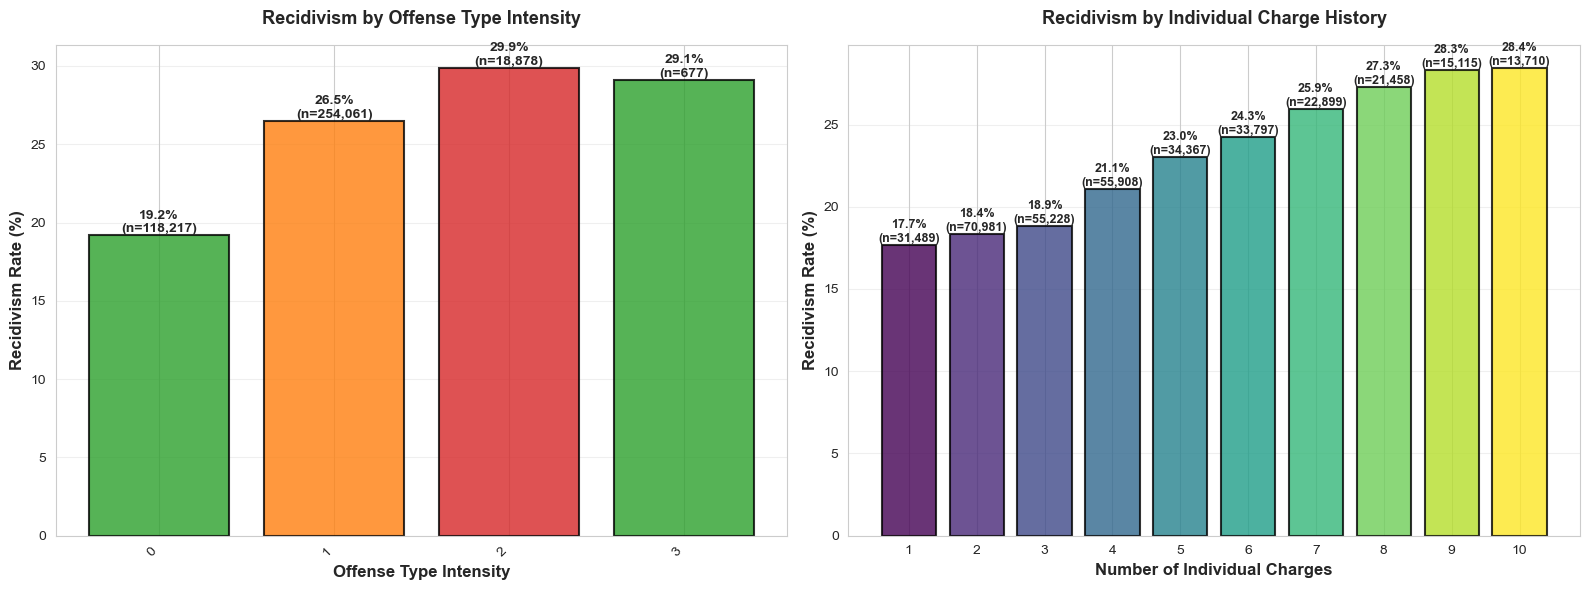

✓ Visualization saved as '5_2_3c_recidivism_intensity_and_individual_charges.png'

All visualizations created successfully!
Three separate 1x2 plots have been generated:
  1. 5_2_1_overall_recidivism_rate.png
  2. 5_2_2_recidivism_by_demographics.png
  3. 5_2_3a_recidivism_severity_and_category.png
  4. 5_2_3b_recidivism_charge_count_and_history.png
  5. 5_2_3c_recidivism_intensity_and_individual_charges.png


In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

df = pd.read_csv('no_summaries_cleaned_modeling_features.csv')

# Set style for all plots
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (12, 6)

# ============================================================================
# 5.2.1 Overall Recidivism Rates - Visualization (1x2 format)
# ============================================================================

print("Creating visualization for 5.2.1 Overall Recidivism Rates...\n")

fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Left plot: Overall recidivism distribution (Bar chart)
unique_defs = df['citationcomplaintnumber'].nunique()
recid_count = df[df['pretrial_recidivism'] == 1]['citationcomplaintnumber'].nunique()
no_recid_count = unique_defs - recid_count

categories = ['Reoffended', 'Did Not Reoffend']
counts = [recid_count, no_recid_count]
percentages = [recid_count/unique_defs*100, no_recid_count/unique_defs*100]
colors = ['#d62728', '#2ca02c']

# Create bar plot
bars = axes[0].bar(categories, counts, color=colors, alpha=0.8, edgecolor='black', linewidth=1.5)

# Add count and percentage labels on bars
for i, (bar, count, pct) in enumerate(zip(bars, counts, percentages)):
    height = bar.get_height()
    axes[0].text(bar.get_x() + bar.get_width()/2., height,
            f'{count:,}\n({pct:.2f}%)',
            ha='center', va='bottom', fontsize=12, fontweight='bold')

axes[0].set_ylabel('Number of Defendants', fontsize=12, fontweight='bold')
axes[0].set_title('Statewide Pretrial Recidivism Rate: 24.86%', 
             fontsize=13, fontweight='bold', pad=15)
axes[0].set_ylim(0, max(counts) * 1.15)
axes[0].grid(axis='y', alpha=0.3)

# Right plot: Pie chart
wedges, texts, autotexts = axes[1].pie(counts, labels=categories, autopct='%1.2f%%',
                                        colors=colors, startangle=90, textprops={'fontsize': 11, 'fontweight': 'bold'})
axes[1].set_title('Distribution of Recidivism Outcomes\n(n = 381,376 unique defendants)',
                 fontsize=13, fontweight='bold', pad=15)

# Make percentage text more readable
for autotext in autotexts:
    autotext.set_color('white')
    autotext.set_fontsize(11)
    autotext.set_fontweight('bold')

plt.tight_layout()
plt.savefig('5_2_1_overall_recidivism_rate.png', dpi=300, bbox_inches='tight')
plt.show()

print("✓ Visualization saved as '5_2_1_overall_recidivism_rate.png'\n")

# ============================================================================
# 5.2.2 Recidivism by Demographics - Visualization (1x2 format)
# ============================================================================

print("Creating visualization for 5.2.2 Recidivism by Demographics...\n")

fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Age Group Analysis (Left)
age_groups_order = ['Under_25', '25-34', '35-44', '45_Plus']
age_data = []
for age_grp in age_groups_order:
    if age_grp in df['age_group'].values:
        age_subset = df[df['age_group'] == age_grp]
        unique_defs = age_subset['citationcomplaintnumber'].nunique()
        recid_defs = age_subset[age_subset['pretrial_recidivism'] == 1]['citationcomplaintnumber'].nunique()
        rate = (recid_defs / unique_defs * 100) if unique_defs > 0 else 0
        age_data.append({'Age Group': age_grp, 'Rate': rate, 'Count': unique_defs})

age_df = pd.DataFrame(age_data)
age_labels = ['Under 25', '25-34', '35-44', '45+']

bars1 = axes[0].bar(age_labels, age_df['Rate'], color='steelblue', alpha=0.8, edgecolor='black', linewidth=1.5)
axes[0].set_ylabel('Recidivism Rate (%)', fontsize=12, fontweight='bold')
axes[0].set_title('Recidivism by Age Group', fontsize=13, fontweight='bold', pad=15)
axes[0].set_ylim(0, 35)
axes[0].grid(axis='y', alpha=0.3)

for i, (bar, rate, count) in enumerate(zip(bars1, age_df['Rate'], age_df['Count'])):
    height = bar.get_height()
    axes[0].text(bar.get_x() + bar.get_width()/2., height,
                f'{rate:.2f}%\n(n={count:,})',
                ha='center', va='bottom', fontsize=10, fontweight='bold')

# Age as Continuous Predictor (Right)
age_bins = np.arange(16, 76, 5)
bin_labels = [f'{int(age_bins[i])}-{int(age_bins[i+1])}' for i in range(len(age_bins)-1)]
df['age_bin'] = pd.cut(df['age_at_offense'], bins=age_bins)

continuous_data = []
for age_range in df['age_bin'].unique():
    if pd.notna(age_range):
        age_subset = df[df['age_bin'] == age_range]
        unique_defs = age_subset['citationcomplaintnumber'].nunique()
        recid_defs = age_subset[age_subset['pretrial_recidivism'] == 1]['citationcomplaintnumber'].nunique()
        rate = (recid_defs / unique_defs * 100) if unique_defs > 0 else 0
        continuous_data.append({'Age Range': age_range, 'Rate': rate, 'Count': unique_defs})

continuous_df = pd.DataFrame(continuous_data).sort_values('Age Range')
age_range_labels = [f'{int(x.left)}-{int(x.right)}' for x in continuous_df['Age Range']]

axes[1].plot(range(len(age_range_labels)), continuous_df['Rate'], marker='o', linewidth=2.5, 
             markersize=8, color='darkred', label='Recidivism Rate')
axes[1].fill_between(range(len(age_range_labels)), continuous_df['Rate'], alpha=0.3, color='red')
axes[1].set_xlabel('Age Range (years)', fontsize=12, fontweight='bold')
axes[1].set_ylabel('Recidivism Rate (%)', fontsize=12, fontweight='bold')
axes[1].set_title('Age as Continuous Predictor of Recidivism', fontsize=13, fontweight='bold', pad=15)
axes[1].set_xticks(range(len(age_range_labels)))
axes[1].set_xticklabels(age_range_labels, rotation=45, ha='right')
axes[1].set_ylim(20, 30)
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('5_2_2_recidivism_by_demographics.png', dpi=300, bbox_inches='tight')
plt.show()

print("✓ Visualization saved as '5_2_2_recidivism_by_demographics.png'\n")

# ============================================================================
# 5.2.3 Recidivism by Offense Characteristics - Visualization
# Divided into THREE separate 1x2 visualizations
# ============================================================================

print("Creating visualization for 5.2.3 Recidivism by Offense Characteristics...\n")

# FIRST 1x2 PLOT: Charge Severity & Crime Category
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Left: By Charge Severity
severity_data = []
for sev in sorted(df['max_charge_severity'].dropna().unique()):
    sev_subset = df[df['max_charge_severity'] == sev]
    unique_defs = sev_subset['citationcomplaintnumber'].nunique()
    recid_defs = sev_subset[sev_subset['pretrial_recidivism'] == 1]['citationcomplaintnumber'].nunique()
    rate = (recid_defs / unique_defs * 100) if unique_defs > 0 else 0
    severity_data.append({'Severity': int(sev), 'Rate': rate, 'Count': unique_defs})
severity_df = pd.DataFrame(severity_data)

# Filter out severity levels 0 and 1
severity_df = severity_df[~severity_df['Severity'].isin([0, 1])]

bars_sev = axes[0].bar(severity_df['Severity'], severity_df['Rate'], 
                           color='#1f77b4', alpha=0.8, edgecolor='black', linewidth=1.5)
axes[0].set_xlabel('Charge Severity Level', fontsize=12, fontweight='bold')
axes[0].set_ylabel('Recidivism Rate (%)', fontsize=12, fontweight='bold')
axes[0].set_title('Recidivism by Maximum Charge Severity', fontsize=13, fontweight='bold', pad=15)
axes[0].set_xticks(severity_df['Severity'])
axes[0].grid(axis='y', alpha=0.3)
for bar, rate, count in zip(bars_sev, severity_df['Rate'], severity_df['Count']):
    height = bar.get_height()
    axes[0].text(bar.get_x() + bar.get_width()/2., height,
                   f'{rate:.1f}%',
                   ha='center', va='bottom', fontsize=10, fontweight='bold')

# Right: By Crime Category
crime_categories = []
for label, flag in [('Drug-related', 'drug_flag'), ('Violent', 'violent_flag'), 
                     ('Property', 'property_flag')]:
    crime_subset = df[df[flag] == 1]
    unique_defs = crime_subset['citationcomplaintnumber'].nunique()
    recid_defs = crime_subset[crime_subset['pretrial_recidivism'] == 1]['citationcomplaintnumber'].nunique()
    rate = (recid_defs / unique_defs * 100) if unique_defs > 0 else 0
    crime_categories.append({'Category': label, 'Rate': rate, 'Count': unique_defs})

other_subset = df[(df['drug_flag'] == 0) & (df['violent_flag'] == 0) & (df['property_flag'] == 0)]
unique_defs = other_subset['citationcomplaintnumber'].nunique()
recid_defs = other_subset[other_subset['pretrial_recidivism'] == 1]['citationcomplaintnumber'].nunique()
rate = (recid_defs / unique_defs * 100) if unique_defs > 0 else 0
crime_categories.append({'Category': 'Other/Mixed', 'Rate': rate, 'Count': unique_defs})

crime_df = pd.DataFrame(crime_categories)
colors_crime = ['#ff7f0e', '#d62728', '#2ca02c', '#7f7f7f']
bars_crime = axes[1].bar(crime_df['Category'], crime_df['Rate'], 
                             color=colors_crime, alpha=0.8, edgecolor='black', linewidth=1.5)
axes[1].set_ylabel('Recidivism Rate (%)', fontsize=12, fontweight='bold')
axes[1].set_title('Recidivism by Crime Category', fontsize=13, fontweight='bold', pad=15)
axes[1].set_xticklabels(crime_df['Category'], rotation=45, ha='right')
axes[1].set_ylim(0, 40)
axes[1].grid(axis='y', alpha=0.3)

for bar, rate, count in zip(bars_crime, crime_df['Rate'], crime_df['Count']):
    height = bar.get_height()
    axes[1].text(bar.get_x() + bar.get_width()/2., height,
                   f'{rate:.2f}%\n(n={count:,})',
                   ha='center', va='bottom', fontsize=10, fontweight='bold')

plt.tight_layout()
plt.savefig('5_2_3a_recidivism_severity_and_category.png', dpi=300, bbox_inches='tight')
plt.show()

print("✓ Visualization saved as '5_2_3a_recidivism_severity_and_category.png'\n")

# SECOND 1x2 PLOT: Charge Count & Prior History
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Left: By Number of Charges
charge_count_data = []
for num_ch in sorted(df['num_charges_case'].dropna().unique())[:5]:
    charge_subset = df[df['num_charges_case'] == num_ch]
    unique_defs = charge_subset['citationcomplaintnumber'].nunique()
    recid_defs = charge_subset[charge_subset['pretrial_recidivism'] == 1]['citationcomplaintnumber'].nunique()
    rate = (recid_defs / unique_defs * 100) if unique_defs > 0 else 0
    charge_count_data.append({'Num_Charges': int(num_ch), 'Rate': rate, 'Count': unique_defs})

charge_count_df = pd.DataFrame(charge_count_data)
x_positions = np.arange(len(charge_count_df))
axes[0].plot(x_positions, charge_count_df['Rate'], 
                marker='s', linewidth=2.5, markersize=8, color='#9467bd', label='Recidivism Rate')
axes[0].fill_between(x_positions, charge_count_df['Rate'], alpha=0.3, color='purple')
axes[0].set_xlabel('Number of Charges in Case', fontsize=12, fontweight='bold')
axes[0].set_ylabel('Recidivism Rate (%)', fontsize=12, fontweight='bold')
axes[0].set_title('Recidivism by Case Complexity (Charge Count)', fontsize=13, fontweight='bold', pad=15)
axes[0].set_xticks(x_positions)
axes[0].set_xticklabels(charge_count_df['Num_Charges'].astype(int))
axes[0].set_ylim(20, 28)
axes[0].grid(True, alpha=0.3)

# Right: By Prior Criminal History & Prior Recidivism
prior_offense_data = []
for value, label in [(1, 'With Prior Offenses'), (0, 'Without Prior Offenses')]:
    subset = df[df['has_prior_offense'] == value]
    unique_defs = subset['citationcomplaintnumber'].nunique()
    recid_defs = subset[subset['pretrial_recidivism'] == 1]['citationcomplaintnumber'].nunique()
    rate = (recid_defs / unique_defs * 100) if unique_defs > 0 else 0
    prior_offense_data.append({'Label': label, 'Rate': rate, 'Count': unique_defs})

prior_recid_data = []
for value, label in [(1, 'Prior Recidivism History'), (0, 'No Prior Recidivism')]:
    subset = df[df['prev_recid_flag'] == value]
    unique_defs = subset['citationcomplaintnumber'].nunique()
    recid_defs = subset[subset['pretrial_recidivism'] == 1]['citationcomplaintnumber'].nunique()
    rate = (recid_defs / unique_defs * 100) if unique_defs > 0 else 0
    prior_recid_data.append({'Label': label, 'Rate': rate, 'Count': unique_defs})

history_data = prior_offense_data + prior_recid_data
history_df = pd.DataFrame(history_data)
colors_history = ['#e41a1c', '#377eb8', '#e41a1c', '#377eb8']
x_pos = np.arange(len(history_df))
bars_history = axes[1].bar(x_pos, history_df['Rate'], 
                              color=colors_history, alpha=0.8, edgecolor='black', linewidth=1.5)
axes[1].set_ylabel('Recidivism Rate (%)', fontsize=12, fontweight='bold')
axes[1].set_title('Recidivism by Prior Offense & Recidivism History', fontsize=13, fontweight='bold', pad=15)
axes[1].set_xticks(x_pos)
axes[1].set_xticklabels(history_df['Label'], rotation=45, ha='right')
axes[1].set_ylim(0, 45)
axes[1].grid(axis='y', alpha=0.3)

for bar, rate, count in zip(bars_history, history_df['Rate'], history_df['Count']):
    height = bar.get_height()
    axes[1].text(bar.get_x() + bar.get_width()/2., height,
                   f'{rate:.2f}%\n(n={count:,})',
                   ha='center', va='bottom', fontsize=9, fontweight='bold')

plt.tight_layout()
plt.savefig('5_2_3b_recidivism_charge_count_and_history.png', dpi=300, bbox_inches='tight')
plt.show()

print("✓ Visualization saved as '5_2_3b_recidivism_charge_count_and_history.png'\n")

# THIRD 1x2 PLOT: Offense Type Intensity & Individual Charge History
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Left: Offense Type Intensity
offense_intensity_data = []
for intensity in sorted(df['offense_type_intensity'].dropna().unique()):
    intensity_subset = df[df['offense_type_intensity'] == intensity]
    unique_defs = intensity_subset['citationcomplaintnumber'].nunique()
    recid_defs = intensity_subset[intensity_subset['pretrial_recidivism'] == 1]['citationcomplaintnumber'].nunique()
    rate = (recid_defs / unique_defs * 100) if unique_defs > 0 else 0
    offense_intensity_data.append({'Intensity': intensity, 'Rate': rate, 'Count': unique_defs})

intensity_df = pd.DataFrame(offense_intensity_data)
colors_intensity = ['#2ca02c', '#ff7f0e', '#d62728'][:len(intensity_df)]
bars_intensity = axes[0].bar(range(len(intensity_df)), intensity_df['Rate'], 
                              color=colors_intensity, alpha=0.8, edgecolor='black', linewidth=1.5)
axes[0].set_xlabel('Offense Type Intensity', fontsize=12, fontweight='bold')
axes[0].set_ylabel('Recidivism Rate (%)', fontsize=12, fontweight='bold')
axes[0].set_title('Recidivism by Offense Type Intensity', fontsize=13, fontweight='bold', pad=15)
axes[0].set_xticks(range(len(intensity_df)))
axes[0].set_xticklabels(intensity_df['Intensity'], rotation=45, ha='right')
axes[0].grid(axis='y', alpha=0.3)

for i, (bar, rate, count) in enumerate(zip(bars_intensity, intensity_df['Rate'], intensity_df['Count'])):
    height = bar.get_height()
    axes[0].text(bar.get_x() + bar.get_width()/2., height,
                 f'{rate:.1f}%\n(n={count:,})',
                 ha='center', va='bottom', fontsize=10, fontweight='bold')

# Right: Number of Charges in Individual History
charge_indiv_data = []
for num_ch in sorted(df['num_charges_individual'].dropna().unique())[:10]:
    indiv_subset = df[df['num_charges_individual'] == num_ch]
    unique_defs = indiv_subset['citationcomplaintnumber'].nunique()
    recid_defs = indiv_subset[indiv_subset['pretrial_recidivism'] == 1]['citationcomplaintnumber'].nunique()
    rate = (recid_defs / unique_defs * 100) if unique_defs > 0 else 0
    charge_indiv_data.append({'Num_Charges': int(num_ch), 'Rate': rate, 'Count': unique_defs})

charge_indiv_df = pd.DataFrame(charge_indiv_data)
x_positions_indiv = np.arange(len(charge_indiv_df))

colors_indiv = plt.cm.viridis(np.linspace(0, 1, len(charge_indiv_df)))
bars_indiv = axes[1].bar(x_positions_indiv, charge_indiv_df['Rate'], 
                           color=colors_indiv, alpha=0.8, edgecolor='black', linewidth=1.5)
axes[1].set_xlabel('Number of Individual Charges', fontsize=12, fontweight='bold')
axes[1].set_ylabel('Recidivism Rate (%)', fontsize=12, fontweight='bold')
axes[1].set_title('Recidivism by Individual Charge History', fontsize=13, fontweight='bold', pad=15)
axes[1].set_xticks(x_positions_indiv)
axes[1].set_xticklabels(charge_indiv_df['Num_Charges'].astype(int))
axes[1].grid(axis='y', alpha=0.3)

for bar, rate, count in zip(bars_indiv, charge_indiv_df['Rate'], charge_indiv_df['Count']):
    height = bar.get_height()
    axes[1].text(bar.get_x() + bar.get_width()/2., height,
                 f'{rate:.1f}%\n(n={count:,})',
                 ha='center', va='bottom', fontsize=9, fontweight='bold')

plt.tight_layout()
plt.savefig('5_2_3c_recidivism_intensity_and_individual_charges.png', dpi=300, bbox_inches='tight')
plt.show()

print("✓ Visualization saved as '5_2_3c_recidivism_intensity_and_individual_charges.png'\n")

print("=" * 80)
print("All visualizations created successfully!")
print("Three separate 1x2 plots have been generated:")
print("  1. 5_2_1_overall_recidivism_rate.png")
print("  2. 5_2_2_recidivism_by_demographics.png")
print("  3. 5_2_3a_recidivism_severity_and_category.png")
print("  4. 5_2_3b_recidivism_charge_count_and_history.png")
print("  5. 5_2_3c_recidivism_intensity_and_individual_charges.png")
print("=" * 80)

✓ Saved: race_ethnicity_recidivism_bars.png
✓ Saved: race_ethnicity_recidivism_heatmap_stats.png

✓ All visualizations completed!


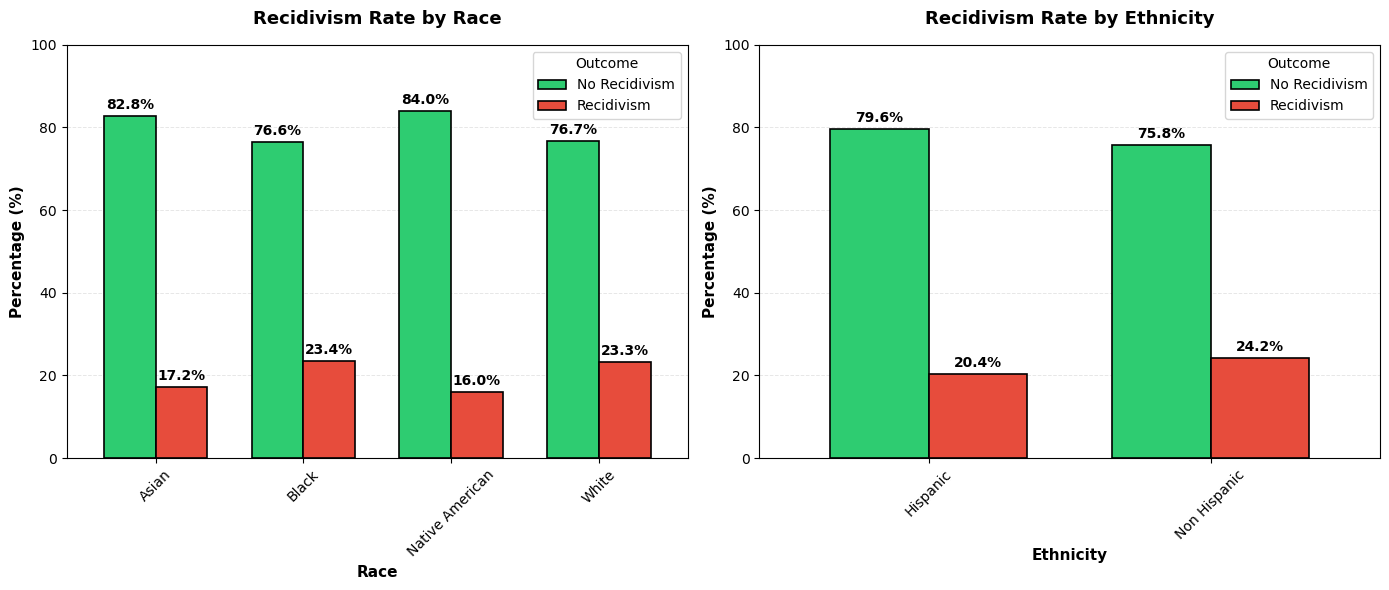

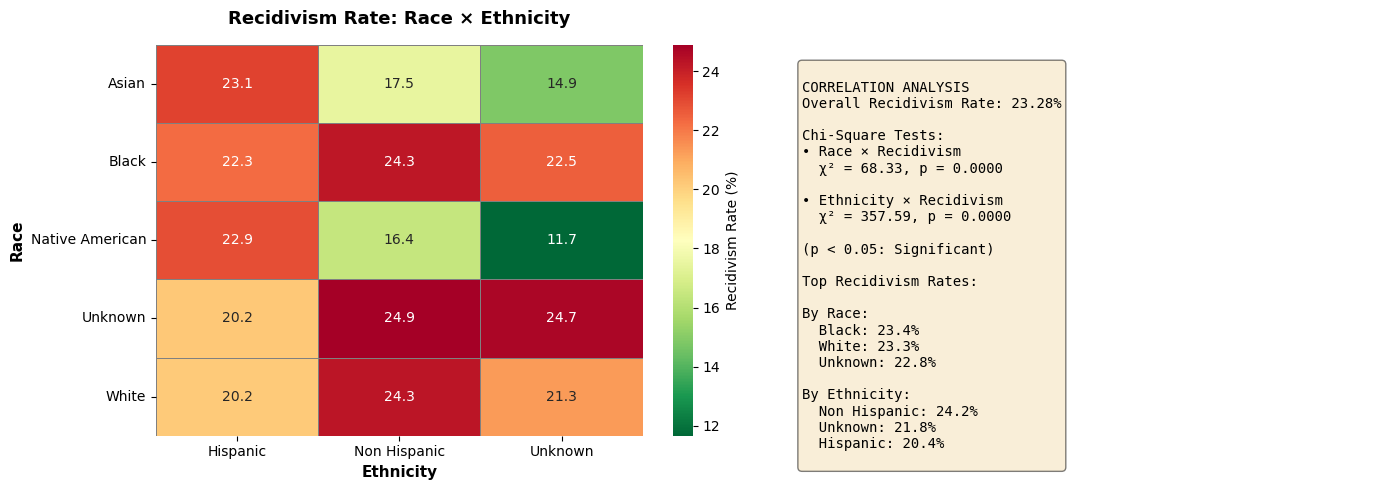

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import chi2_contingency

# Read data
df = pd.read_csv('FINAL_features.csv')

# Create race label mapping
race_mapping = {
    'A': 'Asian',
    'B': 'Black',
    'I': 'Native American',
    'U': 'Unknown',
    'W': 'White'
}
df['race_label'] = df['race_y'].map(race_mapping)

# ============ FIGURE 1: Race and Ethnicity Bar Charts ============
fig1, axes1 = plt.subplots(1, 2, figsize=(14, 6))

# 1. Race vs Recidivism (excluding 'Unknown')
ax1 = axes1[0]
df_filtered = df[df['race_label'] != 'Unknown']
race_recid = pd.crosstab(df_filtered['race_label'], df_filtered['pretrial_recidivism'], normalize='index') * 100
race_recid.plot(kind='bar', ax=ax1, color=['#2ecc71', '#e74c3c'], width=0.7, edgecolor='black', linewidth=1.2)

# Add percentage labels on bars
for container in ax1.containers:
    ax1.bar_label(container, fmt='%.1f%%', padding=3, fontweight='bold', fontsize=10)

ax1.set_title('Recidivism Rate by Race', fontweight='bold', fontsize=13, pad=15)
ax1.set_xlabel('Race', fontweight='bold', fontsize=11)
ax1.set_ylabel('Percentage (%)', fontweight='bold', fontsize=11)
ax1.legend(['No Recidivism', 'Recidivism'], title='Outcome', title_fontsize=10, fontsize=10)
ax1.tick_params(axis='x', rotation=45, labelsize=10)
ax1.tick_params(axis='y', labelsize=10)
ax1.set_ylim(0, 100)
ax1.grid(axis='y', alpha=0.3, linestyle='--', linewidth=0.7)
ax1.set_axisbelow(True)

# 2. Ethnicity vs Recidivism (excluding 'Unknown')
ax2 = axes1[1]
df_filtered_eth = df[df['ethnicity'] != 'Unknown']
eth_recid = pd.crosstab(df_filtered_eth['ethnicity'], df_filtered_eth['pretrial_recidivism'], normalize='index') * 100
eth_recid.plot(kind='bar', ax=ax2, color=['#2ecc71', '#e74c3c'], width=0.7, edgecolor='black', linewidth=1.2)

# Add percentage labels on bars
for container in ax2.containers:
    ax2.bar_label(container, fmt='%.1f%%', padding=3, fontweight='bold', fontsize=10)

ax2.set_title('Recidivism Rate by Ethnicity', fontweight='bold', fontsize=13, pad=15)
ax2.set_xlabel('Ethnicity', fontweight='bold', fontsize=11)
ax2.set_ylabel('Percentage (%)', fontweight='bold', fontsize=11)
ax2.legend(['No Recidivism', 'Recidivism'], title='Outcome', title_fontsize=10, fontsize=10)
ax2.tick_params(axis='x', rotation=45, labelsize=10)
ax2.tick_params(axis='y', labelsize=10)
ax2.set_ylim(0, 100)
ax2.grid(axis='y', alpha=0.3, linestyle='--', linewidth=0.7)
ax2.set_axisbelow(True)

plt.tight_layout()
plt.savefig('race_ethnicity_recidivism_bars.png', dpi=300, bbox_inches='tight')
print("✓ Saved: race_ethnicity_recidivism_bars.png")

# ============ FIGURE 2: Heatmap and Statistics ============
fig2, axes2 = plt.subplots(1, 2, figsize=(14, 5))

# 3. Race × Ethnicity Heatmap
ax3 = axes2[0]
recid_heatmap = df.pivot_table(values='pretrial_recidivism', 
                                 index='race_label', columns='ethnicity', aggfunc='mean') * 100
sns.heatmap(recid_heatmap, annot=True, fmt='.1f', cmap='RdYlGn_r', ax=ax3, 
            cbar_kws={'label': 'Recidivism Rate (%)'}, linewidths=0.5, linecolor='gray')
ax3.set_title('Recidivism Rate: Race × Ethnicity', fontweight='bold', fontsize=13, pad=15)
ax3.set_ylabel('Race', fontweight='bold', fontsize=11)
ax3.set_xlabel('Ethnicity', fontweight='bold', fontsize=11)

# 4. Statistical Information
ax4 = axes2[1]
ax4.axis('off')

# Chi-square tests
chi2_race, p_race = chi2_contingency(pd.crosstab(df['race_label'], df['pretrial_recidivism']))[:2]
chi2_eth, p_eth = chi2_contingency(pd.crosstab(df['ethnicity'], df['pretrial_recidivism']))[:2]

stats = f"""
CORRELATION ANALYSIS
Overall Recidivism Rate: {df['pretrial_recidivism'].mean()*100:.2f}%

Chi-Square Tests:
• Race × Recidivism
  χ² = {chi2_race:.2f}, p = {p_race:.4f}
  
• Ethnicity × Recidivism
  χ² = {chi2_eth:.2f}, p = {p_eth:.4f}

(p < 0.05: Significant)

Top Recidivism Rates:
"""

# By race
race_rates = df.groupby('race_label')['pretrial_recidivism'].mean().sort_values(ascending=False)
stats += "\nBy Race:\n"
for race, rate in race_rates.head(3).items():
    stats += f"  {race}: {rate*100:.1f}%\n"

# By ethnicity
eth_rates = df.groupby('ethnicity')['pretrial_recidivism'].mean().sort_values(ascending=False)
stats += "\nBy Ethnicity:\n"
for eth, rate in eth_rates.head(3).items():
    stats += f"  {eth}: {rate*100:.1f}%\n"

ax4.text(0.05, 0.95, stats, transform=ax4.transAxes, fontsize=10, 
         verticalalignment='top', fontfamily='monospace',
         bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))

plt.tight_layout()
plt.savefig('race_ethnicity_recidivism_heatmap_stats.png', dpi=300, bbox_inches='tight')
print("✓ Saved: race_ethnicity_recidivism_heatmap_stats.png")

print("\n✓ All visualizations completed!")

In [7]:
import pandas as pd
from scipy.stats import chi2_contingency

df = pd.read_csv('FINAL_features.csv')

print("=== KEY STATISTICS ===\n")

# 1. 整体累犯率
overall_rate = df['pretrial_recidivism'].mean() * 100
print(f"Overall Recidivism Rate: {overall_rate:.2f}%\n")

# 2. 按Race分组
print("By Race:")
race_stats = df.groupby('race_y')['pretrial_recidivism'].agg(['count', 'sum', 'mean'])
race_stats['mean'] = race_stats['mean'] * 100
print(race_stats)
print()

# 3. 按Ethnicity分组
print("By Ethnicity:")
eth_stats = df.groupby('ethnicity')['pretrial_recidivism'].agg(['count', 'sum', 'mean'])
eth_stats['mean'] = eth_stats['mean'] * 100
print(eth_stats)
print()

# 4. 最大和最小的累犯率差异
print("Disparity Analysis:")
race_rates = df.groupby('race_y')['pretrial_recidivism'].mean() * 100
eth_rates = df.groupby('ethnicity')['pretrial_recidivism'].mean() * 100
print(f"Race - Highest: {race_rates.max():.2f}%, Lowest: {race_rates.min():.2f}%, Difference: {race_rates.max() - race_rates.min():.2f}%")
print(f"Ethnicity - Highest: {eth_rates.max():.2f}%, Lowest: {eth_rates.min():.2f}%, Difference: {eth_rates.max() - eth_rates.min():.2f}%")

=== KEY STATISTICS ===

Overall Recidivism Rate: 23.28%

By Race:
         count      sum       mean
race_y                            
A         2637    454.0  17.216534
B       122151  28632.0  23.439841
I          405     65.0  16.049383
U         2870    653.0  22.752613
W       306172  71287.0  23.283318

By Ethnicity:
               count      sum       mean
ethnicity                               
Hispanic       35573   7258.0  20.403115
Non Hispanic  336248  81469.0  24.228843
Unknown        47188  10297.0  21.821226

Disparity Analysis:
Race - Highest: 23.44%, Lowest: 16.05%, Difference: 7.39%
Ethnicity - Highest: 24.23%, Lowest: 20.40%, Difference: 3.83%


In [13]:
"""
Extract statistics for analyzing Recidivism by Offense Characteristics
"""

# ============================================================================
# 1. OFFENSE TYPE INTENSITY ANALYSIS
# ============================================================================
print("="*80)
print("1. OFFENSE TYPE INTENSITY ANALYSIS")
print("="*80)

intensity_stats = []
for intensity in sorted(df['offense_type_intensity'].dropna().unique()):
    intensity_subset = df[df['offense_type_intensity'] == intensity]
    unique_defs = intensity_subset['citationcomplaintnumber'].nunique()
    recid_defs = intensity_subset[intensity_subset['pretrial_recidivism'] == 1]['citationcomplaintnumber'].nunique()
    rate = (recid_defs / unique_defs * 100) if unique_defs > 0 else 0
    intensity_stats.append({
        'Intensity': intensity,
        'Total Defendants': unique_defs,
        'Recidivism Cases': recid_defs,
        'Rate': rate
    })

intensity_df_stats = pd.DataFrame(intensity_stats)
print(intensity_df_stats.to_string(index=False))
print(f"\nOverall Recidivism Rate: {df[df['pretrial_recidivism']==1]['citationcomplaintnumber'].nunique() / df['citationcomplaintnumber'].nunique() * 100:.2f}%")
print()

# ============================================================================
# 2. INDIVIDUAL CHARGE HISTORY ANALYSIS
# ============================================================================
print("="*80)
print("2. INDIVIDUAL CHARGE HISTORY ANALYSIS")
print("="*80)

indiv_charge_stats = []
for num_ch in sorted(df['num_charges_individual'].dropna().unique())[:10]:
    indiv_subset = df[df['num_charges_individual'] == num_ch]
    unique_defs = indiv_subset['citationcomplaintnumber'].nunique()
    recid_defs = indiv_subset[indiv_subset['pretrial_recidivism'] == 1]['citationcomplaintnumber'].nunique()
    rate = (recid_defs / unique_defs * 100) if unique_defs > 0 else 0
    indiv_charge_stats.append({
        'Charges': int(num_ch),
        'Total Defendants': unique_defs,
        'Recidivism Cases': recid_defs,
        'Rate': rate
    })

indiv_charge_df_stats = pd.DataFrame(indiv_charge_stats)
print(indiv_charge_df_stats.to_string(index=False))

# Calculate rate increase
min_rate = indiv_charge_df_stats['Rate'].min()
max_rate = indiv_charge_df_stats['Rate'].max()
print(f"\nRate Increase from {indiv_charge_df_stats['Charges'].min()} to {indiv_charge_df_stats['Charges'].max()} charges: {max_rate - min_rate:.1f} percentage points")
print(f"Percentage Increase: {((max_rate - min_rate) / min_rate * 100):.1f}%")
print()

# ============================================================================
# 3. CASE COMPLEXITY (Number of Charges per Case) ANALYSIS
# ============================================================================
print("="*80)
print("3. CASE COMPLEXITY (Number of Charges per Case) ANALYSIS")
print("="*80)

case_charge_stats = []
for num_ch in sorted(df['num_charges_case'].dropna().unique())[:5]:
    case_subset = df[df['num_charges_case'] == num_ch]
    unique_defs = case_subset['citationcomplaintnumber'].nunique()
    recid_defs = case_subset[case_subset['pretrial_recidivism'] == 1]['citationcomplaintnumber'].nunique()
    rate = (recid_defs / unique_defs * 100) if unique_defs > 0 else 0
    case_charge_stats.append({
        'Charges per Case': int(num_ch),
        'Total Defendants': unique_defs,
        'Recidivism Cases': recid_defs,
        'Rate': rate
    })

case_charge_df_stats = pd.DataFrame(case_charge_stats)
print(case_charge_df_stats.to_string(index=False))
print()

# ============================================================================
# 4. CHARGE SEVERITY ANALYSIS
# ============================================================================
print("="*80)
print("4. CHARGE SEVERITY ANALYSIS")
print("="*80)

severity_stats = []
for sev in sorted(df['max_charge_severity'].dropna().unique()):
    sev_subset = df[df['max_charge_severity'] == sev]
    unique_defs = sev_subset['citationcomplaintnumber'].nunique()
    recid_defs = sev_subset[sev_subset['pretrial_recidivism'] == 1]['citationcomplaintnumber'].nunique()
    rate = (recid_defs / unique_defs * 100) if unique_defs > 0 else 0
    severity_stats.append({
        'Severity Level': int(sev),
        'Total Defendants': unique_defs,
        'Recidivism Cases': recid_defs,
        'Rate': rate
    })

severity_df_stats = pd.DataFrame(severity_stats)
print(severity_df_stats.to_string(index=False))
print()

# ============================================================================
# 5. CRIME CATEGORY ANALYSIS
# ============================================================================
print("="*80)
print("5. CRIME CATEGORY ANALYSIS")
print("="*80)

crime_cat_stats = []
for label, flag in [('Drug-related', 'drug_flag'), ('Violent', 'violent_flag'), ('Property', 'property_flag')]:
    cat_subset = df[df[flag] == 1]
    unique_defs = cat_subset['citationcomplaintnumber'].nunique()
    recid_defs = cat_subset[cat_subset['pretrial_recidivism'] == 1]['citationcomplaintnumber'].nunique()
    rate = (recid_defs / unique_defs * 100) if unique_defs > 0 else 0
    crime_cat_stats.append({
        'Category': label,
        'Total Defendants': unique_defs,
        'Recidivism Cases': recid_defs,
        'Rate': rate
    })

other_subset = df[(df['drug_flag'] == 0) & (df['violent_flag'] == 0) & (df['property_flag'] == 0)]
unique_defs = other_subset['citationcomplaintnumber'].nunique()
recid_defs = other_subset[other_subset['pretrial_recidivism'] == 1]['citationcomplaintnumber'].nunique()
rate = (recid_defs / unique_defs * 100) if unique_defs > 0 else 0
crime_cat_stats.append({
    'Category': 'Other/Mixed',
    'Total Defendants': unique_defs,
    'Recidivism Cases': recid_defs,
    'Rate': rate
})

crime_cat_df_stats = pd.DataFrame(crime_cat_stats)
print(crime_cat_df_stats.to_string(index=False))
print()

# ============================================================================
# 6. CRIMINAL HISTORY ANALYSIS
# ============================================================================
print("="*80)
print("6. CRIMINAL HISTORY ANALYSIS")
print("="*80)

# With Prior Offenses
with_prior = df[df['has_prior_offense'] == 1]
unique_with = with_prior['citationcomplaintnumber'].nunique()
recid_with = with_prior[with_prior['pretrial_recidivism'] == 1]['citationcomplaintnumber'].nunique()
rate_with = (recid_with / unique_with * 100) if unique_with > 0 else 0

# Without Prior Offenses
without_prior = df[df['has_prior_offense'] == 0]
unique_without = without_prior['citationcomplaintnumber'].nunique()
recid_without = without_prior[without_prior['pretrial_recidivism'] == 1]['citationcomplaintnumber'].nunique()
rate_without = (recid_without / unique_without * 100) if unique_without > 0 else 0

print(f"With Prior Offenses:")
print(f"  Total Defendants: {unique_with:,}")
print(f"  Recidivism Cases: {recid_with:,}")
print(f"  Recidivism Rate: {rate_with:.2f}%")
print()

print(f"Without Prior Offenses:")
print(f"  Total Defendants: {unique_without:,}")
print(f"  Recidivism Cases: {recid_without:,}")
print(f"  Recidivism Rate: {rate_without:.2f}%")
print()

# Prior Recidivism History
with_prev_recid = df[df['prev_recid_flag'] == 1]
unique_prev = with_prev_recid['citationcomplaintnumber'].nunique()
recid_prev = with_prev_recid[with_prev_recid['pretrial_recidivism'] == 1]['citationcomplaintnumber'].nunique()
rate_prev = (recid_prev / unique_prev * 100) if unique_prev > 0 else 0

# No Prior Recidivism
without_prev_recid = df[df['prev_recid_flag'] == 0]
unique_no_prev = without_prev_recid['citationcomplaintnumber'].nunique()
recid_no_prev = without_prev_recid[without_prev_recid['pretrial_recidivism'] == 1]['citationcomplaintnumber'].nunique()
rate_no_prev = (recid_no_prev / unique_no_prev * 100) if unique_no_prev > 0 else 0

print(f"With Prior Recidivism History:")
print(f"  Total Defendants: {unique_prev:,}")
print(f"  Recidivism Cases: {recid_prev:,}")
print(f"  Recidivism Rate: {rate_prev:.2f}%")
print()

print(f"Without Prior Recidivism:")
print(f"  Total Defendants: {unique_no_prev:,}")
print(f"  Recidivism Cases: {recid_no_prev:,}")
print(f"  Recidivism Rate: {rate_no_prev:.2f}%")
print()

print(f"Difference (With vs Without Prior Offenses): {rate_with - rate_without:.2f} percentage points")
print(f"Difference (With vs Without Prior Recidivism): {rate_prev - rate_no_prev:.2f} percentage points")

1. OFFENSE TYPE INTENSITY ANALYSIS
 Intensity  Total Defendants  Recidivism Cases      Rate
         0            118217             22665 19.172369
         1            254061             67318 26.496786
         2             18878              5636 29.854858
         3               677               197 29.098966

Overall Recidivism Rate: 24.86%

2. INDIVIDUAL CHARGE HISTORY ANALYSIS
 Charges  Total Defendants  Recidivism Cases      Rate
       1             31489              5573 17.698244
       2             70981             13028 18.354207
       3             55228             10415 18.858188
       4             55908             11796 21.098948
       5             34367              7918 23.039544
       6             33797              8203 24.271385
       7             22899              5940 25.939997
       8             21458              5854 27.281200
       9             15115              4279 28.309626
      10             13710              3897 28.424508

Ra

In [14]:
"""
Calculate correlation metrics for all features with pretrial_recidivism
Produces output formatted for Appendix B
"""

import numpy as np
import pandas as pd
from scipy.stats import chi2_contingency, pearsonr

# Define numeric and categorical features
numeric_features = [
    'age_at_offense', 'days_since_last_offense', 'num_charges_individual',
    'num_charges_case', 'max_charge_severity', 'min_charge_severity',
    'avg_charge_severity', 'std_charge_severity', 'range_charge_severity',
    'case_duration_days', 'county_recid_rate', 'offense_year'
]

categorical_features = [
    'age_group', 'drug_flag', 'violent_flag', 'property_flag',
    'prev_recid_flag', 'has_prior_offense', 'multi_charge_flag',
    'multi_county_flag', 'offense_type_intensity', 'supervision_violation_flag',
    'waived_or_dismissed_flag'
]

# Function to calculate Cramér's V
def cramers_v(x, y):
    """Calculate Cramér's V statistic for categorical-categorical association."""
    confusion_matrix = pd.crosstab(x, y)
    chi2 = chi2_contingency(confusion_matrix)[0]
    n = confusion_matrix.sum().sum()
    min_dim = min(confusion_matrix.shape) - 1
    return np.sqrt(chi2 / (n * min_dim)) if min_dim > 0 else 0

# Calculate correlations
correlations = []

# Numeric features - Pearson r
print("Calculating Pearson correlations for numeric features...")
for feature in numeric_features:
    if feature in df.columns:
        valid_idx = df[[feature, 'pretrial_recidivism']].notna().all(axis=1)
        if valid_idx.sum() > 0:
            r, p_value = pearsonr(df.loc[valid_idx, feature], 
                                   df.loc[valid_idx, 'pretrial_recidivism'])
            correlations.append({
                'Feature': feature,
                'Type': 'Numeric',
                'Correlation Metric': 'Pearson r',
                'Correlation Value': r,
                'Sample Size': valid_idx.sum()
            })

# Categorical features - Cramér's V
print("Calculating Cramér's V for categorical features...")
for feature in categorical_features:
    if feature in df.columns:
        valid_idx = df[[feature, 'pretrial_recidivism']].notna().all(axis=1)
        if valid_idx.sum() > 0:
            v = cramers_v(df.loc[valid_idx, feature], 
                         df.loc[valid_idx, 'pretrial_recidivism'])
            correlations.append({
                'Feature': feature,
                'Type': 'Categorical',
                'Correlation Metric': "Cramér's V",
                'Correlation Value': v,
                'Sample Size': valid_idx.sum()
            })

# Create DataFrame and sort by absolute correlation value
corr_df = pd.DataFrame(correlations)
corr_df['Abs_Correlation'] = corr_df['Correlation Value'].abs()
corr_df = corr_df.sort_values('Abs_Correlation', ascending=False).drop('Abs_Correlation', axis=1)

# Display results
print("\n" + "="*100)
print("CORRELATION METRICS FOR PRETRIAL RECIDIVISM")
print("="*100 + "\n")
print(corr_df.to_string(index=False))

# Create formatted table for Appendix B
print("\n" + "="*100)
print("MARKDOWN FORMAT FOR APPENDIX B")
print("="*100 + "\n")

# Header
print("| Feature | Type | Metric | Correlation Value | Sample Size |")
print("|---------|------|--------|-------------------|-------------|")

# Rows
for _, row in corr_df.iterrows():
    print(f"| {row['Feature']} | {row['Type']} | {row['Correlation Metric']} | {row['Correlation Value']:.4f} | {row['Sample Size']:,} |")

# Summary statistics
print("\n" + "="*100)
print("SUMMARY STATISTICS")
print("="*100)
numeric_corrs = corr_df[corr_df['Type'] == 'Numeric']['Correlation Value'].abs()
categorical_corrs = corr_df[corr_df['Type'] == 'Categorical']['Correlation Value'].abs()

print(f"\nNumeric Features (Pearson r):")
print(f"  Mean Absolute Correlation: {numeric_corrs.mean():.4f}")
print(f"  Median Absolute Correlation: {numeric_corrs.median():.4f}")
print(f"  Max Absolute Correlation: {numeric_corrs.max():.4f}")
print(f"  Min Absolute Correlation: {numeric_corrs.min():.4f}")

print(f"\nCategorical Features (Cramér's V):")
print(f"  Mean Absolute Correlation: {categorical_corrs.mean():.4f}")
print(f"  Median Absolute Correlation: {categorical_corrs.median():.4f}")
print(f"  Max Absolute Correlation: {categorical_corrs.max():.4f}")
print(f"  Min Absolute Correlation: {categorical_corrs.min():.4f}")

# Save to CSV for easy reference
corr_df.to_csv('correlation_metrics_recidivism.csv', index=False)
print(f"\nResults saved to: correlation_metrics_recidivism.csv")

Calculating Pearson correlations for numeric features...
Calculating Cramér's V for categorical features...

CORRELATION METRICS FOR PRETRIAL RECIDIVISM

                Feature        Type Correlation Metric  Correlation Value  Sample Size
        prev_recid_flag Categorical         Cramér's V           0.188325       431920
      has_prior_offense Categorical         Cramér's V           0.163902       431920
          property_flag Categorical         Cramér's V           0.126957       431920
 num_charges_individual     Numeric          Pearson r           0.095720       431920
    avg_charge_severity     Numeric          Pearson r           0.074783       431920
    min_charge_severity     Numeric          Pearson r           0.071846       431920
 offense_type_intensity Categorical         Cramér's V           0.069598       431920
           violent_flag Categorical         Cramér's V           0.067749       431920
         age_at_offense     Numeric          Pearson r         

Chart saved as: correlation_visualizations.png


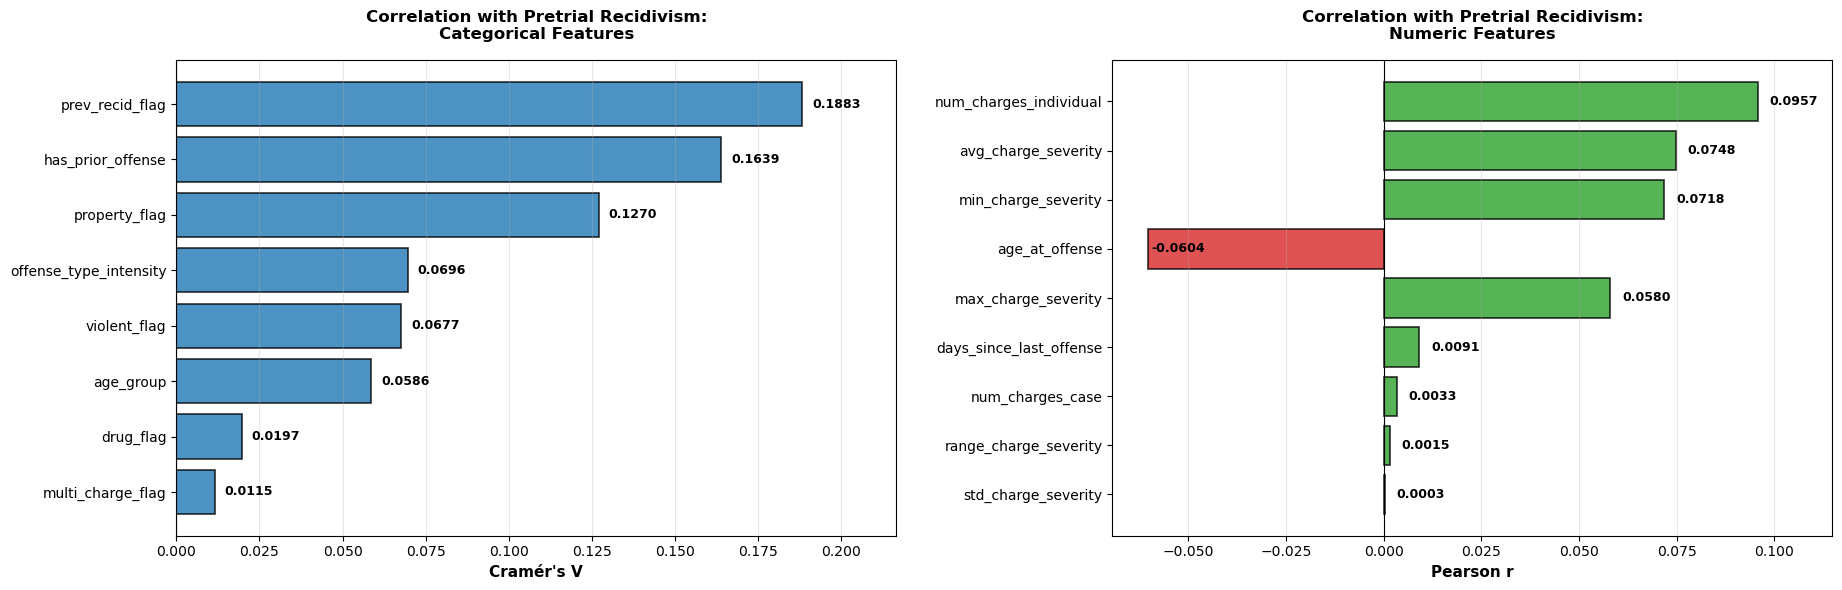


CORRELATION SUMMARY STATISTICS

CATEGORICAL FEATURES (Cramér's V):
  Strongest: multi_charge_flag (0.0115)
  Weakest: prev_recid_flag (0.1883)
  Mean: 0.0883

NUMERIC FEATURES (Pearson r):
  Strongest: num_charges_individual (0.0957)
  Weakest: num_charges_individual (0.0957)
  Mean Absolute: 0.0417


In [18]:
"""
Create bar chart visualizations of correlation metrics sorted high to low
Separate charts for categorical and numeric features
"""

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

# Data from correlation analysis
correlation_data = {
    'Feature': ['prev_recid_flag', 'has_prior_offense', 'property_flag', 
                'num_charges_individual', 'avg_charge_severity', 'min_charge_severity',
                'offense_type_intensity', 'violent_flag', 'age_at_offense', 'age_group',
                'max_charge_severity', 'drug_flag', 'multi_charge_flag', 
                'days_since_last_offense', 'num_charges_case',
                'range_charge_severity', 'std_charge_severity'],
    'Type': ['Categorical', 'Categorical', 'Categorical', 
             'Numeric', 'Numeric', 'Numeric',
             'Categorical', 'Categorical', 'Numeric', 'Categorical',
             'Numeric', 'Categorical', 'Categorical',
             'Numeric', 'Numeric',
             'Numeric', 'Numeric'],
    'Correlation Value': [0.1883, 0.1639, 0.1270,
                         0.0957, 0.0748, 0.0718,
                         0.0696, 0.0677, -0.0604, 0.0586,
                         0.0580, 0.0197, 0.0115,
                         0.0091, 0.0033,
                         0.0015, 0.0003]
}

df_corr = pd.DataFrame(correlation_data)

# Separate by type
categorical = df_corr[df_corr['Type'] == 'Categorical'].copy()
numeric = df_corr[df_corr['Type'] == 'Numeric'].copy()

# Sort by absolute correlation value (descending) - high to low
categorical = categorical.sort_values('Correlation Value', key=abs, ascending=True)
numeric = numeric.sort_values('Correlation Value', key=abs, ascending=True)

# Create figure with 2 subplots
fig, axes = plt.subplots(1, 2, figsize=(18, 6))

# ============================================================================
# CATEGORICAL FEATURES
# ============================================================================
ax1 = axes[0]
colors_cat = ['#d62728' if x < 0 else '#1f77b4' for x in categorical['Correlation Value']]
bars_cat = ax1.barh(range(len(categorical)), categorical['Correlation Value'], 
                     color=colors_cat, alpha=0.8, edgecolor='black', linewidth=1.2)

ax1.set_yticks(range(len(categorical)))
ax1.set_yticklabels(categorical['Feature'], fontsize=10)
ax1.set_xlabel("Cramér's V", fontsize=11, fontweight='bold')
ax1.set_title('Correlation with Pretrial Recidivism:\nCategorical Features', 
              fontsize=12, fontweight='bold', pad=15)
ax1.grid(axis='x', alpha=0.3)
ax1.axvline(x=0, color='black', linewidth=0.8)
ax1.set_xlim(0, max(categorical['Correlation Value']) * 1.15)

# Add value labels on bars
for i, (bar, val) in enumerate(zip(bars_cat, categorical['Correlation Value'])):
    ax1.text(val + 0.003, i, f'{val:.4f}', va='center', fontsize=9, fontweight='bold')

# ============================================================================
# NUMERIC FEATURES
# ============================================================================
ax2 = axes[1]
colors_num = ['#d62728' if x < 0 else '#2ca02c' for x in numeric['Correlation Value']]
bars_num = ax2.barh(range(len(numeric)), numeric['Correlation Value'], 
                     color=colors_num, alpha=0.8, edgecolor='black', linewidth=1.2)

ax2.set_yticks(range(len(numeric)))
ax2.set_yticklabels(numeric['Feature'], fontsize=10)
ax2.set_xlabel("Pearson r", fontsize=11, fontweight='bold')
ax2.set_title('Correlation with Pretrial Recidivism:\nNumeric Features', 
              fontsize=12, fontweight='bold', pad=15)
ax2.grid(axis='x', alpha=0.3)
ax2.axvline(x=0, color='black', linewidth=0.8)
ax2.set_xlim(min(numeric['Correlation Value']) * 1.15, max(numeric['Correlation Value']) * 1.2)

# Add value labels on bars
for i, (bar, val) in enumerate(zip(bars_num, numeric['Correlation Value'])):
    if val > 0:
        offset = 0.003
        ha = 'left'
    else:
        offset = 0.001
        ha = 'left'
    ax2.text(val + offset, i, f'{val:.4f}', va='center', ha=ha, fontsize=9, fontweight='bold')

plt.tight_layout()
# Adjust left margin of right subplot to prevent label overlap
plt.subplots_adjust(left=0.08, right=1, wspace=0.3)
plt.savefig('correlation_visualizations.png', dpi=300, bbox_inches='tight')
print("Chart saved as: correlation_visualizations.png")
plt.show()

# Print summary statistics
print("\n" + "="*80)
print("CORRELATION SUMMARY STATISTICS")
print("="*80)

print("\nCATEGORICAL FEATURES (Cramér's V):")
print(f"  Strongest: {categorical.iloc[0]['Feature']} ({categorical.iloc[0]['Correlation Value']:.4f})")
print(f"  Weakest: {categorical.iloc[-1]['Feature']} ({categorical.iloc[-1]['Correlation Value']:.4f})")
print(f"  Mean: {categorical['Correlation Value'].mean():.4f}")

print("\nNUMERIC FEATURES (Pearson r):")
numeric_abs = numeric['Correlation Value'].abs()
strongest_idx = numeric_abs.idxmax()
print(f"  Strongest: {numeric.loc[strongest_idx, 'Feature']} ({numeric.loc[strongest_idx, 'Correlation Value']:.4f})")
print(f"  Weakest: {numeric.iloc[-1]['Feature']} ({numeric.iloc[-1]['Correlation Value']:.4f})")
print(f"  Mean Absolute: {numeric_abs.mean():.4f}")

✓ Saved: sex_recidivism.png

Sex vs Recidivism Rates:
pretrial_recidivism    0.0    1.0
sex                              
F                    76.89  23.11
M                    76.67  23.33


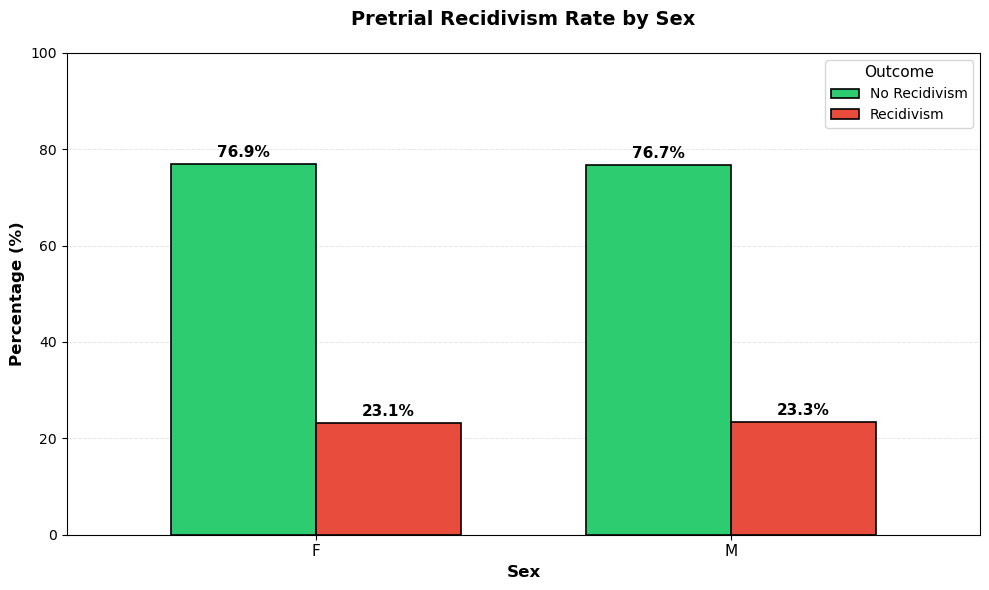

In [4]:
import pandas as pd
import matplotlib.pyplot as plt

df = pd.read_csv('FINAL_features.csv')

# Filter for only Female and Male
df_filtered = df[df['sex'].isin(['F', 'M'])]

fig, ax = plt.subplots(figsize=(8, 6))
sex_recid = pd.crosstab(df_filtered['sex'], df_filtered['pretrial_recidivism'], normalize='index') * 100
sex_recid.plot(kind='bar', ax=ax, color=['#2ecc71', '#e74c3c'])
ax.set_title('Recidivism Rate by Sex (%)', fontweight='bold', fontsize=12)
ax.set_xlabel('Sex', fontweight='bold')
ax.set_ylabel('Percentage (%)', fontweight='bold')
ax.legend(['No', 'Yes'], title='Recidivism')
ax.tick_params(axis='x', rotation=0)
plt.tight_layout()
plt.savefig('sex_recidivism.png', dpi=300, bbox_inches='tight')
print("✓ Saved: sex_recidivism.png")

# Print data
print("\nSex vs Recidivism Rates:")
print(sex_recid.round(2))